In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV

In [2]:
house = pd.read_csv("./kc_house_data.csv")
house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
house.yr_renovated = np.where(house.yr_renovated!=0, 1, 0)

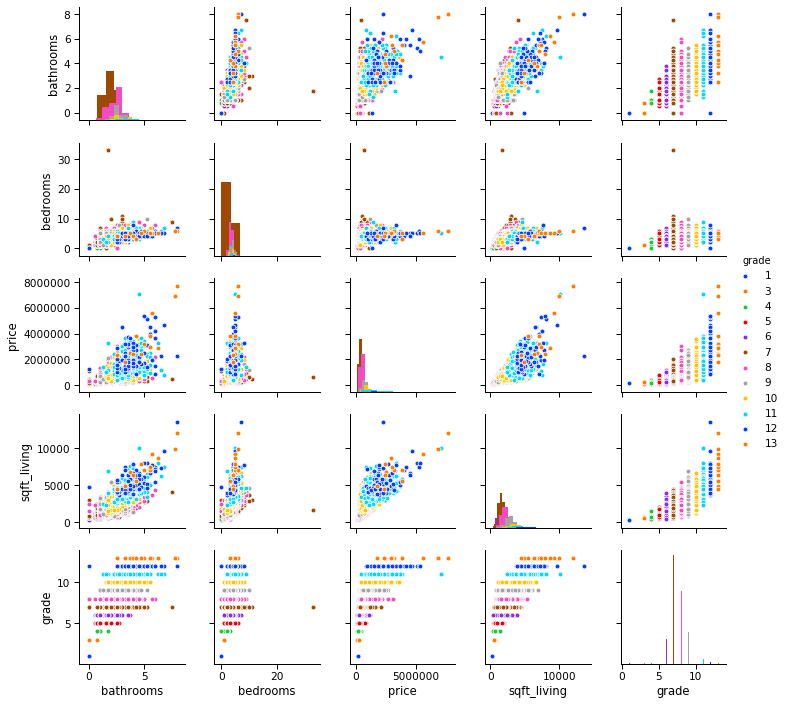

In [4]:
with sns.plotting_context("paper",font_scale=1.2):
    featurePlot = sns.pairplot(house[['bathrooms','bedrooms','price','sqft_living','grade']],height=2,hue="grade",palette="bright",kind="scatter",diag_kind="hist")

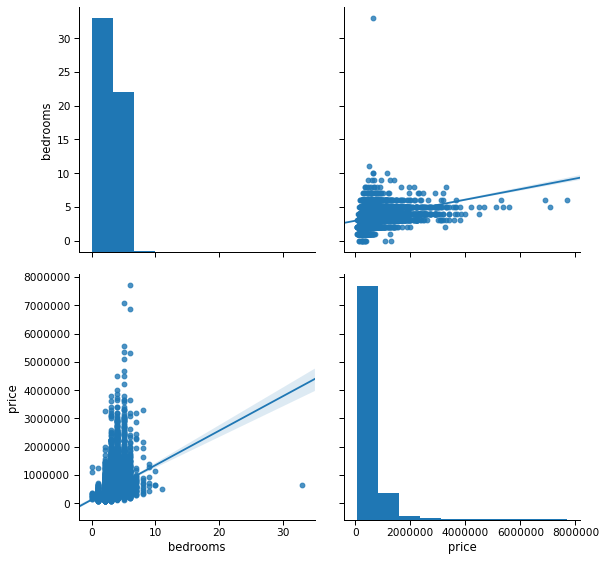

In [5]:
with sns.plotting_context("paper",font_scale=1.2):
    featurePlot = sns.pairplot(house,height=4,vars=["bedrooms","price"],kind="reg")

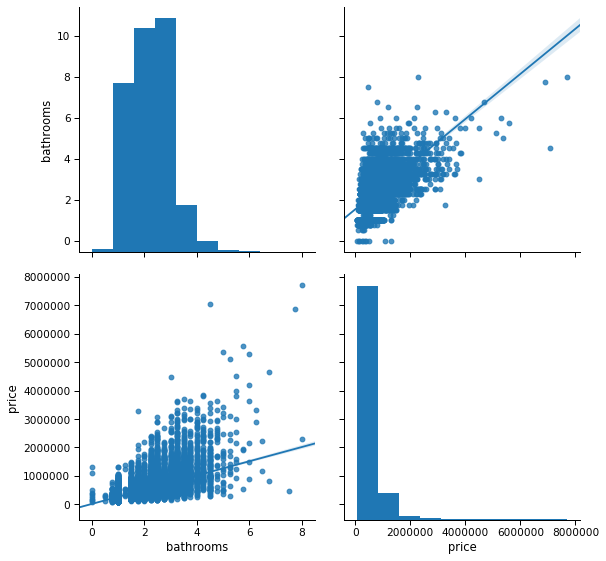

In [6]:
with sns.plotting_context("paper",font_scale=1.2):
    featurePlot = sns.pairplot(house,height=4,vars=["bathrooms","price"],kind="reg")

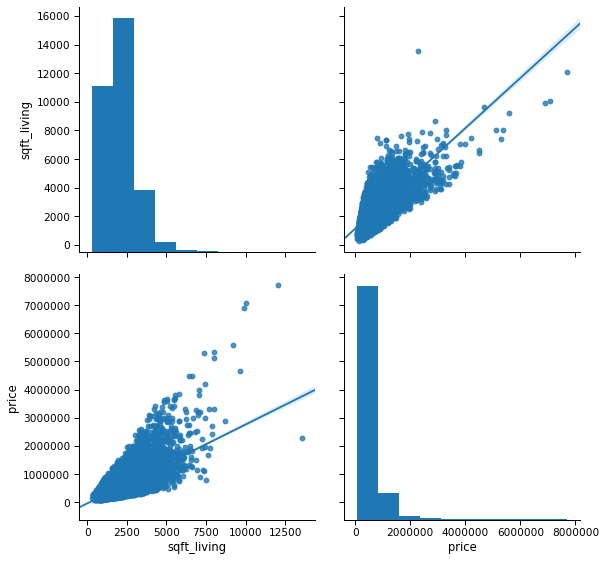

In [7]:
with sns.plotting_context("paper",font_scale=1.2):
    featurePlot = sns.pairplot(house,height=4,vars=["sqft_living","price"],kind="reg")

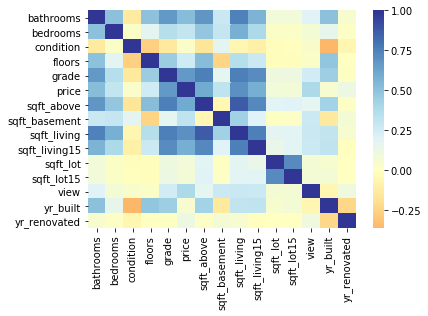

In [8]:
#house = house.drop(['id','date'],axis=1)
unwanted = []
for columnName, columnValue in house.iteritems():
    if type(columnValue[1]) == str:
        unwanted.append(columnName)
wanted = house.columns.difference(unwanted)
sns.heatmap(house[wanted].drop(['id','lat','long','zipcode','waterfront'],axis=1).astype(float).corr(),cmap="RdYlBu",center=0);

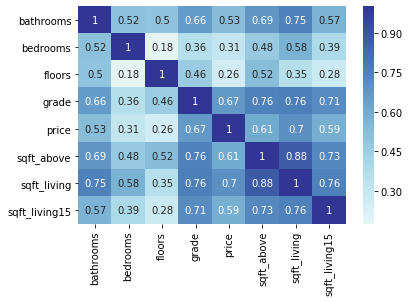

In [25]:
sns.heatmap(house[['bathrooms','bedrooms','floors','grade','price','sqft_above','sqft_living','sqft_living15']].astype(float).corr(),cmap="RdYlBu",center=0,annot=True);

In [10]:
# Save the feature ranking of various methods
ranks = {}
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = np.transpose(minmax.fit_transform(order*np.transpose(np.array([ranks]))))[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

C:\Users\xpeng76\AppData\Local\Continuum\anaconda3\envs\xpeng-python3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


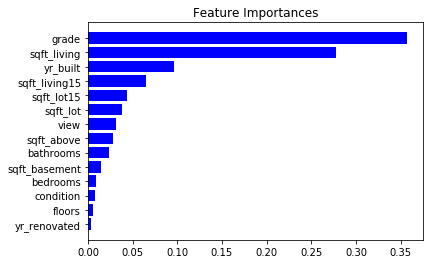

In [11]:
# Use Random Forest Regressor for Feature Ranking
randomForest = RandomForestRegressor(n_jobs=-1,n_estimators=100,warm_start=True)
randomForest.fit(house.drop(['id','date','price','lat','long','zipcode','waterfront'],axis=1).as_matrix(),house.price.values)

features = house.drop(['id','date','price','lat','long','zipcode','waterfront'],axis=1).columns
importance = randomForest.feature_importances_
indices = randomForest.feature_importances_.argsort()
ranks["RF"] = ranking(randomForest.feature_importances_, features);

plt.title('Feature Importances')
plt.barh(range(len(indices)),importance[indices],color='b',align='center')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.show()

C:\Users\xpeng76\AppData\Local\Continuum\anaconda3\envs\xpeng-python3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


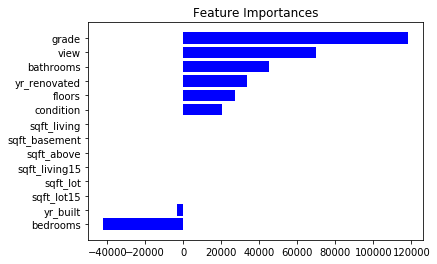

In [12]:
# Linear Regression
linearRegression = LinearRegression(normalize=True)
linearRegression.fit(house.drop(['id','date','price','lat','long','zipcode','waterfront'],axis=1).as_matrix(),house.price.values)

features = house.drop(['id','date','price','lat','long','zipcode','waterfront'],axis=1).columns
importanceLR = linearRegression.coef_
indices = np.argsort(importanceLR)
ranks["LR"] = ranking(np.abs(linearRegression.coef_), features);

plt.title('Feature Importances')
plt.barh(range(len(indices)),importanceLR[indices],color='b',align='center')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.show()

C:\Users\xpeng76\AppData\Local\Continuum\anaconda3\envs\xpeng-python3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


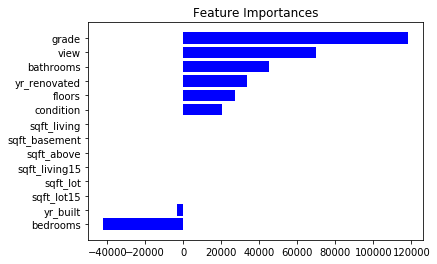

In [13]:
# Ridge
ridge = Ridge(alpha=3)
ridge.fit(house.drop(['id','date','price','lat','long','zipcode','waterfront'],axis=1).as_matrix(),house.price.values)

features = house.drop(['id','date','price','lat','long','zipcode','waterfront'],axis=1).columns
importanceRidge = ridge.coef_
indices = np.argsort(importanceRidge)
ranks["RG"] = ranking(np.abs(ridge.coef_), features);

plt.title('Feature Importances')
plt.barh(range(len(indices)),importanceRidge[indices],color='b',align='center')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.show()

C:\Users\xpeng76\AppData\Local\Continuum\anaconda3\envs\xpeng-python3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\xpeng76\AppData\Local\Continuum\anaconda3\envs\xpeng-python3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 483655900451139.8, tolerance: 291291676192.12994
  positive)


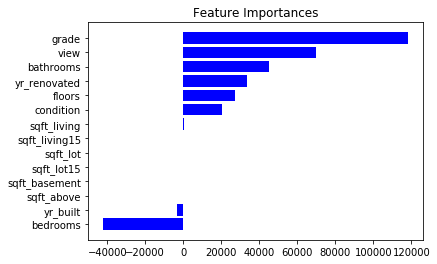

In [14]:
# Lasso
lasso = Lasso(alpha=0.5)
lasso.fit(house.drop(['id','date','price','lat','long','zipcode','waterfront'],axis=1).as_matrix(),house.price.values)

features = house.drop(['id','date','price','lat','long','zipcode','waterfront'],axis=1).columns
importanceLS = lasso.coef_
indices = np.argsort(importanceLS)
ranks["LS"] = ranking(np.abs(lasso.coef_), features);

plt.title('Feature Importances')
plt.barh(range(len(indices)),importanceLS[indices],color='b',align='center')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.show()

C:\Users\xpeng76\AppData\Local\Continuum\anaconda3\envs\xpeng-python3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\xpeng76\AppData\Local\Continuum\anaconda3\envs\xpeng-python3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.


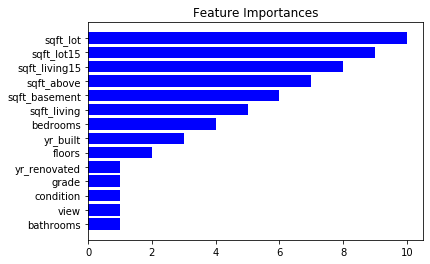

In [15]:
#Use linear regression as the estimator
Linear_regression = LinearRegression(normalize=True).fit(house.drop(['id','date','price','lat','long','zipcode','waterfront'],axis=1).as_matrix(),house.price.values)
#Do RFE until the desired number of features are selected
rfe = RFE(Linear_regression, n_features_to_select=5, verbose =3 )
rfe.fit(house.drop(['id','date','price','lat','long','zipcode','waterfront'],axis=1).as_matrix(),house.price.values)

features = house.drop(['id','date','price','lat','long','zipcode','waterfront'],axis=1).columns
importanceRFE = rfe.ranking_
indices = np.argsort(importanceRFE)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), features)

plt.title('Feature Importances')
plt.barh(range(len(indices)),importanceRFE[indices],color='b',align='center')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.show()

C:\Users\xpeng76\AppData\Local\Continuum\anaconda3\envs\xpeng-python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\xpeng76\AppData\Local\Continuum\anaconda3\envs\xpeng-python3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


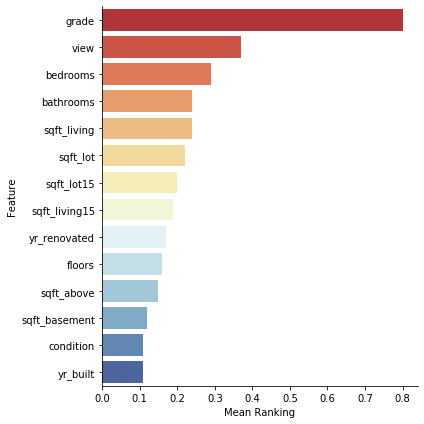

In [16]:
# Get average feature ranking
r = {}
for f in features:
    r[f] = round(np.mean([ranks[method][f] for method in ranks.keys()]), 2)

meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", size=6, palette='RdYlBu');

In [17]:
# Select top 10 features for linear regression

X = house[['grade','view','bathrooms','bedrooms','yr_renovated','sqft_living','sqft_living15','floors','sqft_lot15','sqft_lot']].values
Y = house.price.values

#split the data into training set and test set
train_size = np.round(X.shape[0] * 0.75).astype(np.int32)

X_train = X[0:train_size]
Y_train = Y[0:train_size]

X_test = X[train_size:]
Y_test = Y[train_size:]

poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.fit_transform(X_test)

# Linear Regression
linearRegression = LinearRegression(normalize=True)
linearRegression.fit(X_train,Y_train)

linearPoly = LinearRegression(normalize=True)
linearPoly.fit(X_poly_train,Y_train)

# Ridge
Ridge1 = RidgeCV(alphas=(0.02,0.05,0.1,0.15,0.2,0.5,1,1.0,2,5,10.0,20),cv = 5,normalize=True).fit(X_train,Y_train)
Ridge1_predict = Ridge1.predict(X_test)

Ridge2 = RidgeCV(alphas=(0.02,0.05,0.1,0.15,0.2,0.5,1,1.0,2,5,10.0,20),cv = 5,normalize=True).fit(X_poly_train,Y_train)
Ridge2_predict = Ridge2.predict(X_poly_test)

# Lasso
Lasso1 = LassoCV(alphas = (5,10,20,50,100,200,500),cv = 5,normalize=True).fit(X_train,Y_train)
Lasso1_predict = Lasso1.predict(X_test)

Lasso2 = LassoCV(alphas = (5,10,20,50,100,200,500),cv = 5,normalize=True).fit(X_poly_train,Y_train)
Lasso2_predict = Lasso2.predict(X_poly_test)


C:\Users\xpeng76\AppData\Local\Continuum\anaconda3\envs\xpeng-python3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 784397900853.8125, tolerance: 170939600867.0722
  tol, rng, random, positive)
C:\Users\xpeng76\AppData\Local\Continuum\anaconda3\envs\xpeng-python3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 749929327849.5, tolerance: 173329608186.39062
  tol, rng, random, positive)
C:\Users\xpeng76\AppData\Local\Continuum\anaconda3\envs\xpeng-python3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 950810382074.5, tolerance: 168214204592.36816
  tol, rng, random, positive)
C:\Users\xpeng76\App

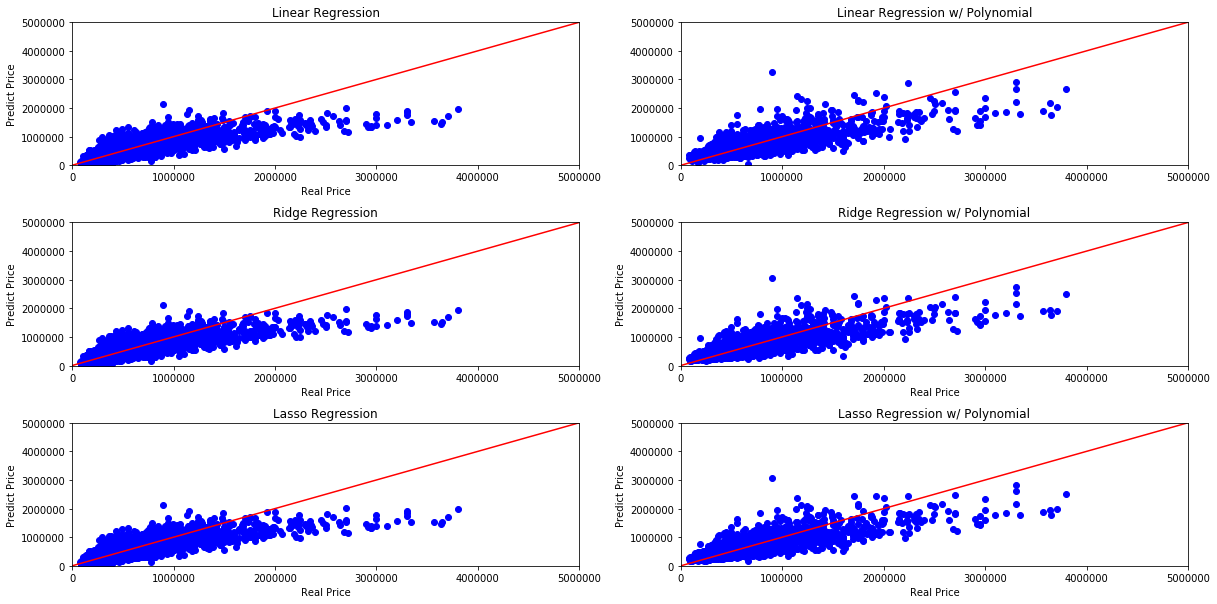

In [18]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(20,10))

ax1.scatter(Y_test, linearRegression.predict(X_test), c='blue')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax1.transAxes
line.set_transform(transform)
ax1.set_title("Linear Regression")
ax1.set_xlabel("Real Price")
ax1.set_ylabel("Predict Price")
ax1.add_line(line)
ax1.set_xlim([0,5000000])
ax1.set_ylim([0,5000000])

ax2.scatter(Y_test, linearPoly.predict(X_poly_test), c='blue')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax2.transAxes
line.set_transform(transform)
ax2.set_title("Linear Regression w/ Polynomial")
ax1.set_xlabel("Real Price")
ax1.set_ylabel("Predict Price")
ax2.add_line(line)
ax2.set_xlim([0,5000000])
ax2.set_ylim([0,5000000])

ax3.scatter(Y_test, Ridge1_predict, c='blue')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax3.transAxes
line.set_transform(transform)
ax3.set_title("Ridge Regression")
ax3.set_xlabel("Real Price")
ax3.set_ylabel("Predict Price")
ax3.add_line(line)
ax3.set_xlim([0,5000000])
ax3.set_ylim([0,5000000])

ax4.scatter(Y_test, Ridge2_predict, c='blue')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax4.transAxes
line.set_transform(transform)
ax4.set_title("Ridge Regression w/ Polynomial")
ax4.set_xlabel("Real Price")
ax4.set_ylabel("Predict Price")
ax4.add_line(line)
ax4.set_xlim([0,5000000])
ax4.set_ylim([0,5000000])

ax5.scatter(Y_test, Lasso1_predict, c='blue')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax5.transAxes
line.set_transform(transform)
ax5.set_title("Lasso Regression")
ax5.set_xlabel("Real Price")
ax5.set_ylabel("Predict Price")
ax5.add_line(line)
ax5.set_xlim([0,5000000])
ax5.set_ylim([0,5000000])

ax6.scatter(Y_test, Lasso2_predict, c='blue')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax6.transAxes
line.set_transform(transform)
ax6.set_title("Lasso Regression w/ Polynomial")
ax6.set_xlabel("Real Price")
ax6.set_ylabel("Predict Price")
ax6.add_line(line)
ax6.set_xlim([0,5000000])
ax6.set_ylim([0,5000000])

fig.subplots_adjust(wspace=0.2,hspace=0.4)
plt.show()

In [19]:
rmseL=np.sqrt(np.mean((linearRegression.predict(X_test)-Y_test)**2))
rmseLP=np.sqrt(np.mean((linearPoly.predict(X_poly_test)-Y_test)**2))
rmseR=np.sqrt(np.mean((Ridge1.predict(X_test)-Y_test)**2))
rmseRP=np.sqrt(np.mean((Ridge2.predict(X_poly_test)-Y_test)**2))
rmseLA=np.sqrt(np.mean((Lasso1.predict(X_test)-Y_test)**2))
rmseLAP=np.sqrt(np.mean((Lasso2.predict(X_poly_test)-Y_test)**2))

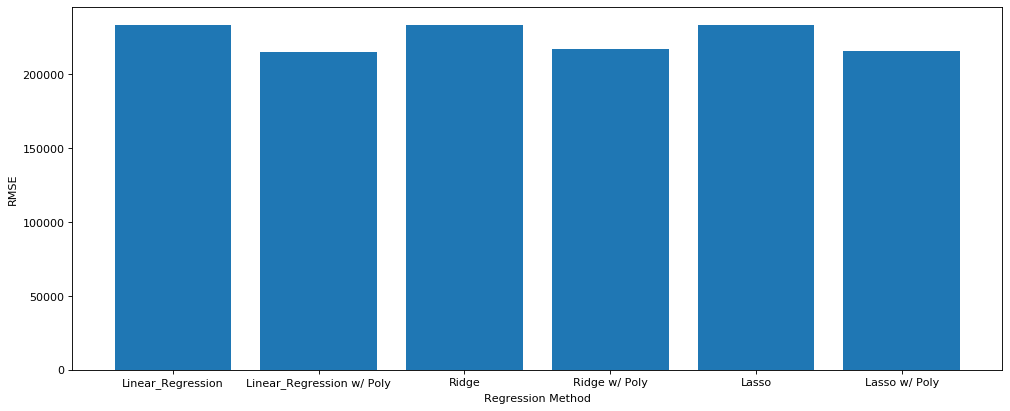

In [20]:
from matplotlib.pyplot import figure
x = ['Linear_Regression', 'Linear_Regression w/ Poly','Ridge','Ridge w/ Poly','Lasso','Lasso w/ Poly']
y = np.array([rmseL, rmseLP, rmseR, rmseRP, rmseLA, rmseLAP])
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar(x,y)
plt.xlabel("Regression Method")
plt.ylabel("RMSE");

In [21]:
print(x)
print(y)

['Linear_Regression', 'Linear_Regression w/ Poly', 'Ridge', 'Ridge w/ Poly', 'Lasso', 'Lasso w/ Poly']
[233371.95542246 215195.19409506 233659.51524717 217365.18633336
 233310.24909887 215590.03046775]
